In [29]:
from sklearn.datasets import load_iris
import pymc as pm
from sklearn.datasets import load_breast_cancer
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Q1.


Output()

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

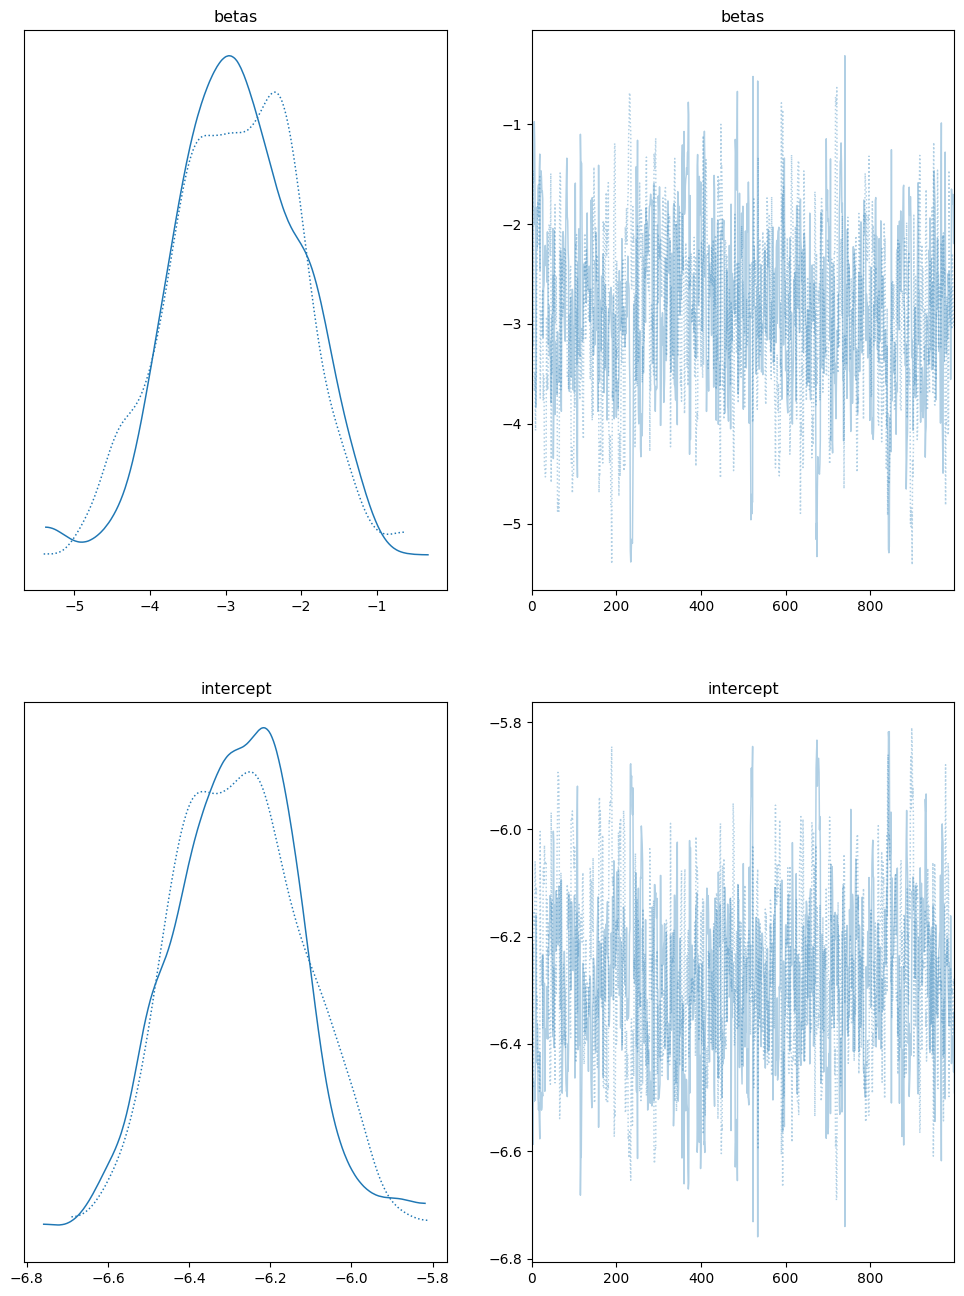

In [30]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
X = X[['mean symmetry']]
X['target'] = breast_cancer.target

# build bayesian logistic regression model (standard link function)
coords = {"observation": X.index.values, "feature": X.drop('target', axis=1).columns.values}
with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("x", X.drop('target', axis=1).values, dims=("observation", "feature"))

    ### priors ###
    betas = pm.Normal("betas", mu=0, sigma=1, shape=x.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    ### linear predictor ###
    mu = intercept + pm.math.dot(x, betas)
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")

    pm.Binomial("y", n=len(X), p=p, observed=X["target"], dims="observation")

with binomial_regression_model:
    idata = pm.sample(draws=1000, tune=2000, target_accept=0.95, return_inferencedata=True)

az.plot_trace(idata, var_names=["betas", "intercept"], figsize=(12, 16), combined=False)


Q3.


Output()

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

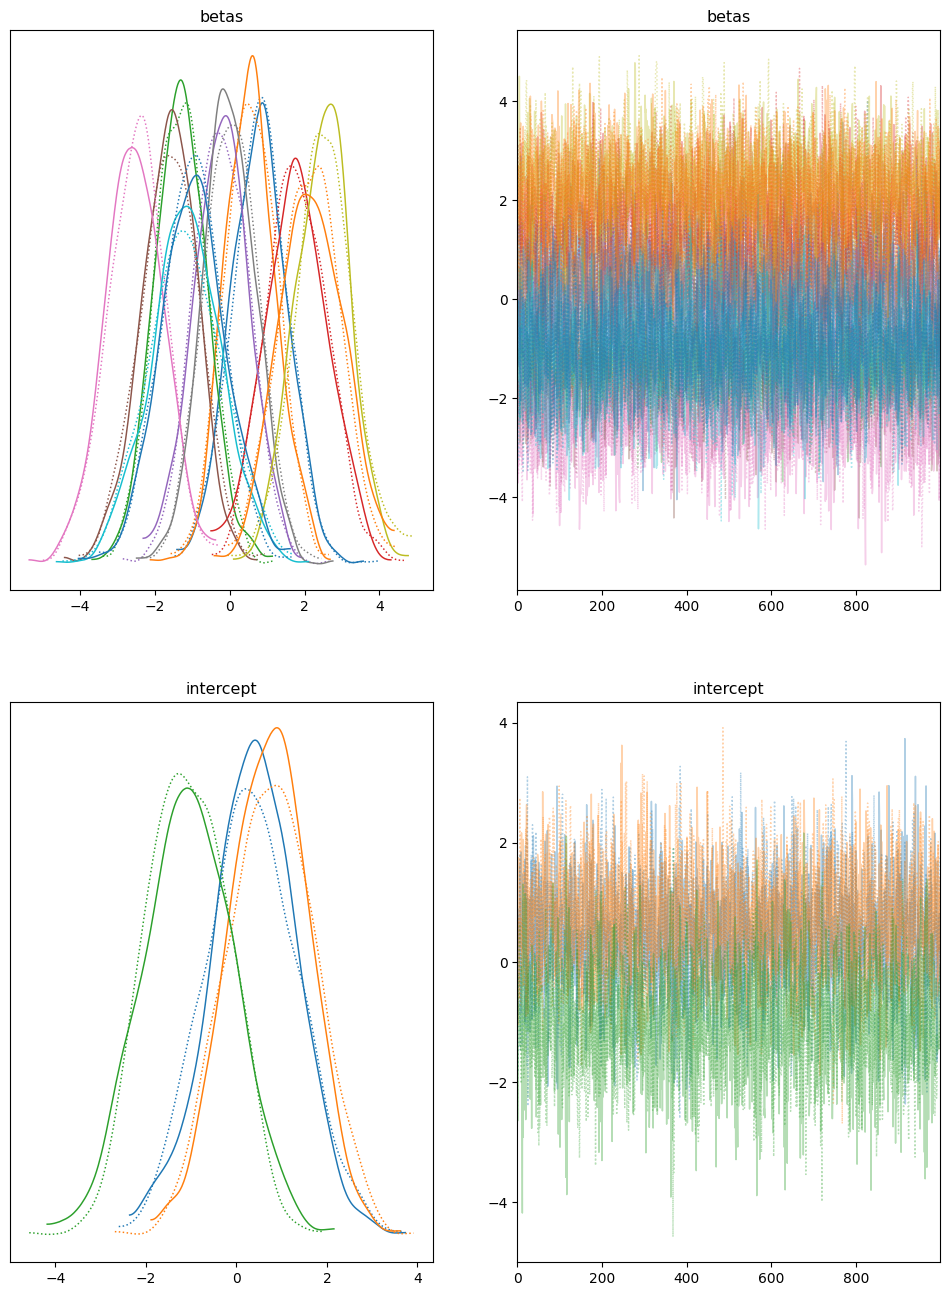

In [31]:
iris = load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
X['target'] = iris.target

coords = {"observation": X.index.values, "feature": X.drop('target', axis=1).columns.values, "category": np.unique(X['target'])}
with pm.Model(coords=coords) as multinomial_regression_model:
    x = pm.Data("x", X.drop('target', axis=1).values, dims=("observation", "feature"))

    ### priors ###
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(x.shape[1], len(np.unique(X['target']))), dims=("feature", "category"))
    intercept = pm.Normal("intercept", mu=0, sigma=1, shape=len(np.unique(X['target'])), dims="category")

    ### linear predictor ###
    mu = intercept + pm.math.dot(x, betas)

    p = pm.Deterministic("p", pm.math.softmax(mu, axis=1), dims=("observation", "category"))
    pm.Categorical("y", p=p, observed=X["target"].values, dims="observation")

with multinomial_regression_model:
    idata = pm.sample(draws=1000, tune=2000, target_accept=0.95, return_inferencedata=True)

az.plot_trace(idata, var_names=["betas", "intercept"], figsize=(12, 16), combined=False)